In [1]:
!nvidia-smi

Sun Aug  3 23:03:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8             17W /   65W |    5854MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

def check_gpu():
    print("="*40)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        total_mem = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
        capability = torch.cuda.get_device_capability(0)
        print("✅ GPU is available and being used.")
        print(f"🖥️  Device     : {gpu_name}")
        print(f"💾 Memory     : {total_mem:.2f} GB")
        print(f"⚙️  Capability : {capability}")
        print(f"📌 Torch Device : {device}")
    else:
        device = torch.device("cpu")
        print("❌ GPU not available. Using CPU instead.")
        print(f"📌 Torch Device : {device}")
    print("="*40)

check_gpu()


✅ GPU is available and being used.
🖥️  Device     : NVIDIA GeForce RTX 3060 Laptop GPU
💾 Memory     : 6.00 GB
⚙️  Capability : (8, 6)
📌 Torch Device : cuda


In [3]:
# Cell 1 — Imports & Config

import os, random
from datetime import datetime

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

# ImageNet normalization
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]


In [4]:
# Cell 2 — Dataset (OpenCV, one random frame per video)

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, folders, transform=None):
        self.samples = []
        for label, f in enumerate(folders):
            p = os.path.join(root_dir, f)
            for fname in os.listdir(p):
                full = os.path.join(p, fname)
                if os.path.isfile(full):
                    self.samples.append((full, label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open {video_path}")
        n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        if n <= 0:
            raise RuntimeError(f"No frames in {video_path}")

        frame_idx = random.randint(0, n - 1)
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()
        cap.release()
        if not ok:
            raise RuntimeError(f"Failed read frame {frame_idx} from {video_path}")

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
# Cell 3 — Transforms & DataLoaders

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

data_root = "../subset"
folders   = ['DFD_original_sequences','DFD_manipulated_sequences']

full_ds = VideoFrameDataset(data_root, folders, transform)
n_train = int(0.8 * len(full_ds))
n_val   = len(full_ds) - n_train
train_ds, val_ds = torch.utils.data.random_split(full_ds, [n_train, n_val])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [6]:
# Cell 4 — MobileNet‐V2 Model

class MobileNetVideo(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        backbone = models.mobilenet_v2(pretrained=True)
        in_f = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

model = MobileNetVideo(num_classes=2).to(device)


c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\mohit/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 60.0MB/s]


In [7]:
# Cell 5 — Trainer with extended metrics & MobileNet checkpoints

class Trainer:
    def __init__(self, model, train_loader, val_loader, device,
                 lr=1e-4, ckpt_dir="MobileNet._checkpoints"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader   = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.ckpt_dir = ckpt_dir
        os.makedirs(ckpt_dir, exist_ok=True)

        self.history = {k: [] for k in [
            "train_loss","train_acc",
            "val_loss","val_acc","val_prec","val_rec","val_f1",
            "val_roc_auc","val_pr_auc"
        ]}

    def train_epoch(self, epoch):
        self.model.train()
        running_loss, preds, trues = 0.0, [], []
        loop = tqdm(self.train_loader,
                    desc=f"Epoch {epoch} ▶ Train",
                    unit="batch", dynamic_ncols=True, leave=True)
        for imgs, labels in loop:
            imgs, labels = imgs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
            out = self.model(imgs)
            loss = self.criterion(out, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            trues.extend(labels.cpu().tolist())

            loop.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc":  f"{100*accuracy_score(trues, preds):.2f}%",
                "lr":   f"{self.optimizer.param_groups[0]['lr']:.1e}"
            })

        tr_loss = running_loss / len(trues)
        tr_acc  = accuracy_score(trues, preds)
        self.history["train_loss"].append(tr_loss)
        self.history["train_acc"].append(tr_acc)
        print(f"→ Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}")

    def validate_epoch(self, epoch):
        self.model.eval()
        running_loss, probs, trues = 0.0, [], []
        loop = tqdm(self.val_loader,
                    desc=f"Epoch {epoch} ▶ Valid",
                    unit="batch", dynamic_ncols=True, leave=True)
        with torch.no_grad():
            for imgs, labels in loop:
                imgs, labels = imgs.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                out = self.model(imgs)
                loss = self.criterion(out, labels)

                running_loss += loss.item() * imgs.size(0)
                p = torch.softmax(out, dim=1)[:,1]
                probs.extend(p.cpu().tolist())
                trues.extend(labels.cpu().tolist())

                loop.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc":  f"{100*accuracy_score(trues, [x>0.5 for x in probs]):.2f}%"
                })

        val_loss = running_loss / len(trues)
        val_acc  = accuracy_score(trues, [x>0.5 for x in probs])
        prec, rec, f1, _ = precision_recall_fscore_support(trues, [x>0.5 for x in probs], average='binary', zero_division=0)
        fpr, tpr, _ = roc_curve(trues, probs)
        roc_auc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(trues, probs)
        pr_auc  = average_precision_score(trues, probs)

        self.history["val_loss"].append(val_loss)
        self.history["val_acc"].append(val_acc)
        self.history["val_prec"].append(prec)
        self.history["val_rec"].append(rec)
        self.history["val_f1"].append(f1)
        self.history["val_roc_auc"].append(roc_auc)
        self.history["val_pr_auc"].append(pr_auc)

        print(f"→ Valid: loss={val_loss:.4f}, acc={val_acc:.4f}")
        return val_acc, (fpr, tpr, pr, rc, trues, probs)

    def save_checkpoint(self, epoch, best=False):
        fn = f"epoch_{epoch}.pth" if not best else "best_model.pth"
        path = os.path.join(self.ckpt_dir, fn)
        torch.save({
            "epoch": epoch,
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict()
        }, path)
        print(f"[Checkpoint] Saved {fn}")

    def fit(self, epochs=20):
        best_acc = 0.0
        for ep in range(1, epochs+1):
            print(f"\n=== Epoch {ep}/{epochs} ===")
            self.train_epoch(ep)
            val_acc, roc_pr = self.validate_epoch(ep)
            self.save_checkpoint(ep)
            if val_acc > best_acc:
                best_acc = val_acc
                self.save_checkpoint(ep, best=True)
        print(f"\nTraining complete. Best val acc: {best_acc:.4f}")
        return roc_pr


In [8]:
# Cell 6 — Run training (20 epochs)

trainer = Trainer(model, train_loader, val_loader, device)


In [9]:
roc_pr_data = trainer.fit(epochs=20)



=== Epoch 1/20 ===


Epoch 1 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.7367, acc=0.5375


Epoch 1 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.6531, acc=0.6250
[Checkpoint] Saved epoch_1.pth
[Checkpoint] Saved best_model.pth

=== Epoch 2/20 ===


Epoch 2 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.6224, acc=0.6125


Epoch 2 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.6851, acc=0.6000
[Checkpoint] Saved epoch_2.pth

=== Epoch 3/20 ===


Epoch 3 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.5593, acc=0.7500


Epoch 3 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.6663, acc=0.5750
[Checkpoint] Saved epoch_3.pth

=== Epoch 4/20 ===


Epoch 4 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.5086, acc=0.7875


Epoch 4 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.7622, acc=0.5750
[Checkpoint] Saved epoch_4.pth

=== Epoch 5/20 ===


Epoch 5 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.4646, acc=0.7750


Epoch 5 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8671, acc=0.5000
[Checkpoint] Saved epoch_5.pth

=== Epoch 6/20 ===


Epoch 6 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.4346, acc=0.8187


Epoch 6 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8715, acc=0.5500
[Checkpoint] Saved epoch_6.pth

=== Epoch 7/20 ===


Epoch 7 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.4071, acc=0.8313


Epoch 7 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8541, acc=0.5250
[Checkpoint] Saved epoch_7.pth

=== Epoch 8/20 ===


Epoch 8 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3340, acc=0.8625


Epoch 8 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.9450, acc=0.5000
[Checkpoint] Saved epoch_8.pth

=== Epoch 9/20 ===


Epoch 9 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3252, acc=0.8688


Epoch 9 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8252, acc=0.6250
[Checkpoint] Saved epoch_9.pth

=== Epoch 10/20 ===


Epoch 10 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3017, acc=0.8938


Epoch 10 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0131, acc=0.5500
[Checkpoint] Saved epoch_10.pth

=== Epoch 11/20 ===


Epoch 11 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3275, acc=0.8500


Epoch 11 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.9675, acc=0.5000
[Checkpoint] Saved epoch_11.pth

=== Epoch 12/20 ===


Epoch 12 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2645, acc=0.8875


Epoch 12 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0806, acc=0.6250
[Checkpoint] Saved epoch_12.pth

=== Epoch 13/20 ===


Epoch 13 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.3312, acc=0.8500


Epoch 13 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0791, acc=0.5750
[Checkpoint] Saved epoch_13.pth

=== Epoch 14/20 ===


Epoch 14 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2654, acc=0.9062


Epoch 14 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.9777, acc=0.6250
[Checkpoint] Saved epoch_14.pth

=== Epoch 15/20 ===


Epoch 15 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2154, acc=0.9313


Epoch 15 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0379, acc=0.6250
[Checkpoint] Saved epoch_15.pth

=== Epoch 16/20 ===


Epoch 16 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2608, acc=0.8875


Epoch 16 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=0.8126, acc=0.6750
[Checkpoint] Saved epoch_16.pth
[Checkpoint] Saved best_model.pth

=== Epoch 17/20 ===


Epoch 17 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2344, acc=0.9062


Epoch 17 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.2461, acc=0.5500
[Checkpoint] Saved epoch_17.pth

=== Epoch 18/20 ===


Epoch 18 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2208, acc=0.9062


Epoch 18 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.2372, acc=0.6000
[Checkpoint] Saved epoch_18.pth

=== Epoch 19/20 ===


Epoch 19 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2505, acc=0.8875


Epoch 19 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.1359, acc=0.6750
[Checkpoint] Saved epoch_19.pth

=== Epoch 20/20 ===


Epoch 20 ▶ Train:   0%|          | 0/10 [00:00<?, ?batch/s]

→ Train: loss=0.2481, acc=0.9000


Epoch 20 ▶ Valid:   0%|          | 0/3 [00:00<?, ?batch/s]

→ Valid: loss=1.0337, acc=0.6000
[Checkpoint] Saved epoch_20.pth

Training complete. Best val acc: 0.6750


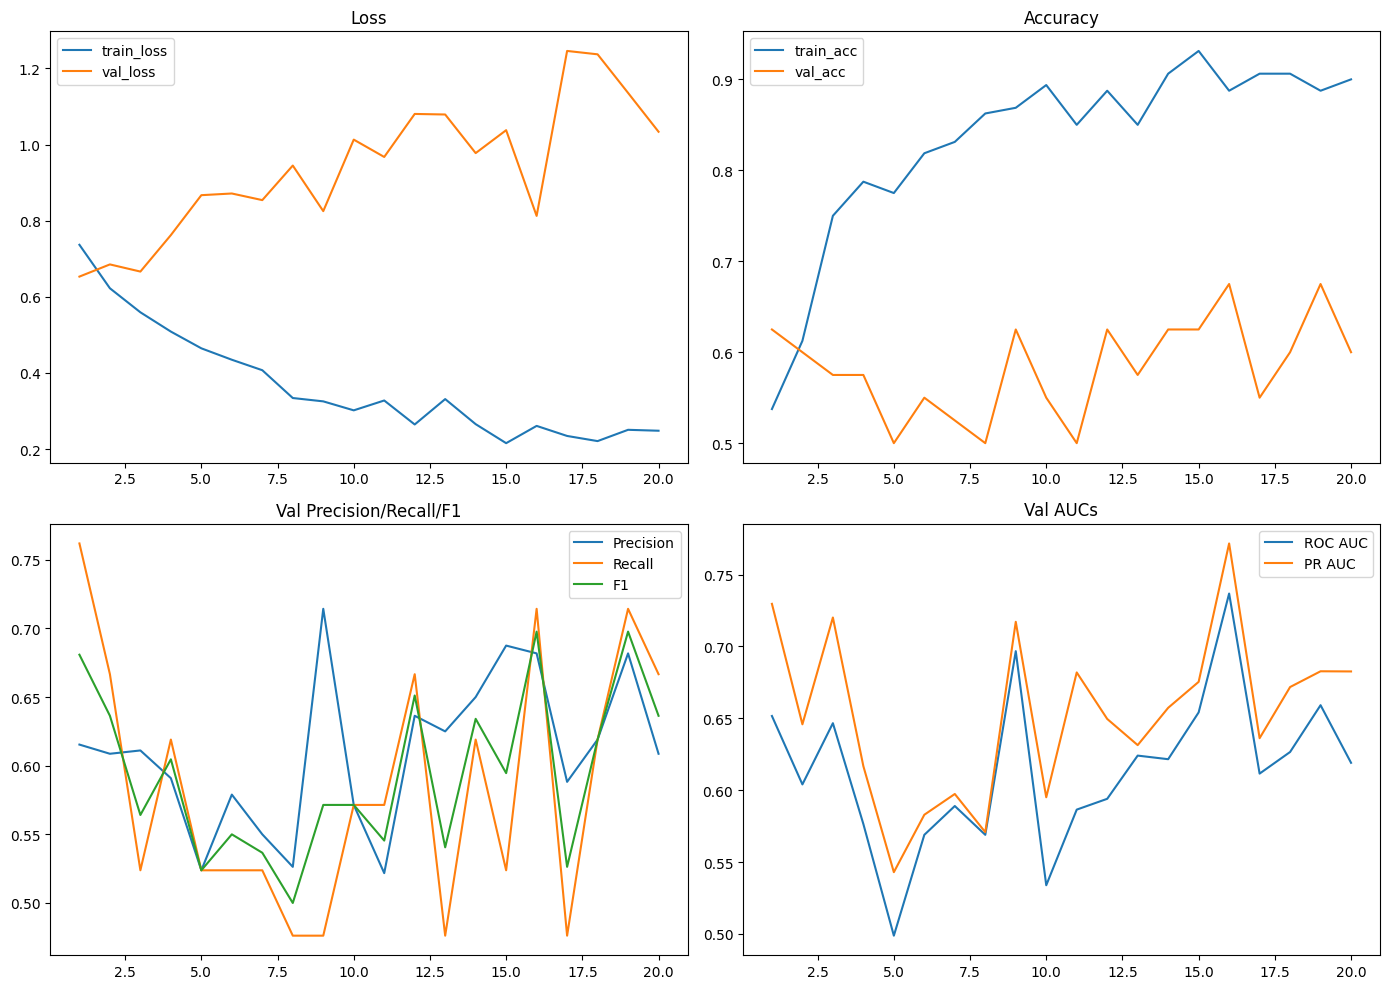

In [10]:
# Cell 7 — Plot Loss, Accuracy, Precision, Recall & F1 over epochs

h = trainer.history
epo = list(range(1, len(h["train_loss"])+1))

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epo, h["train_loss"], label="train_loss")
plt.plot(epo, h["val_loss"] , label="val_loss")
plt.title("Loss"); plt.legend()

plt.subplot(2,2,2)
plt.plot(epo, h["train_acc"], label="train_acc")
plt.plot(epo, h["val_acc"] , label="val_acc")
plt.title("Accuracy"); plt.legend()

plt.subplot(2,2,3)
plt.plot(epo, h["val_prec"], label="Precision")
plt.plot(epo, h["val_rec"] , label="Recall")
plt.plot(epo, h["val_f1"]  , label="F1")
plt.title("Val Precision/Recall/F1"); plt.legend()

plt.subplot(2,2,4)
plt.plot(epo, h["val_roc_auc"], label="ROC AUC")
plt.plot(epo, h["val_pr_auc"] , label="PR AUC")
plt.title("Val AUCs"); plt.legend()

plt.tight_layout()
plt.show()


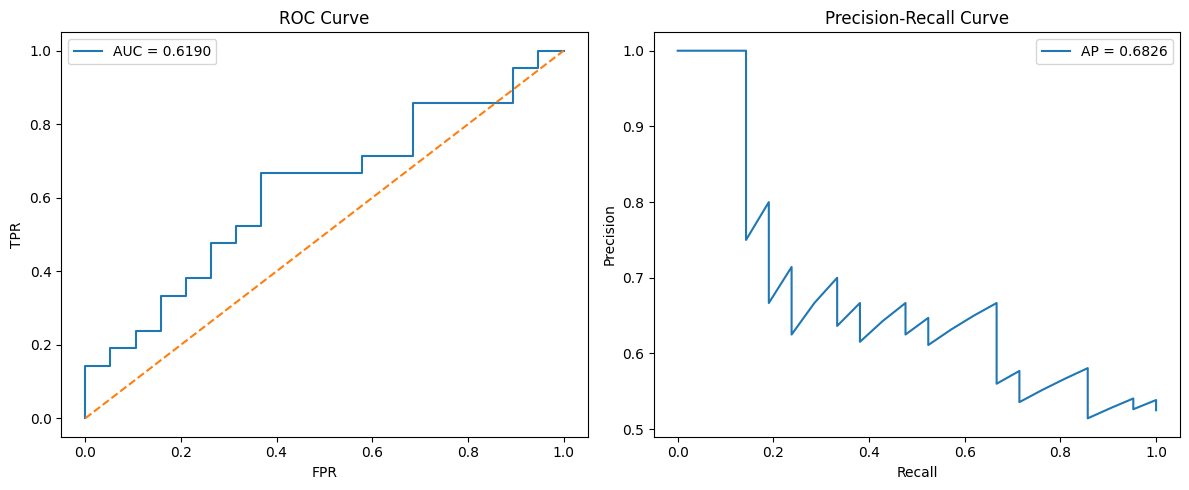

In [11]:
# Cell 8 — ROC & PR curves for final epoch

fpr, tpr, pr, rc, y_true, y_prob = roc_pr_data

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {h['val_roc_auc'][-1]:.4f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rc, pr, label=f"AP = {h['val_pr_auc'][-1]:.4f}")
plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

plt.tight_layout()
plt.show()


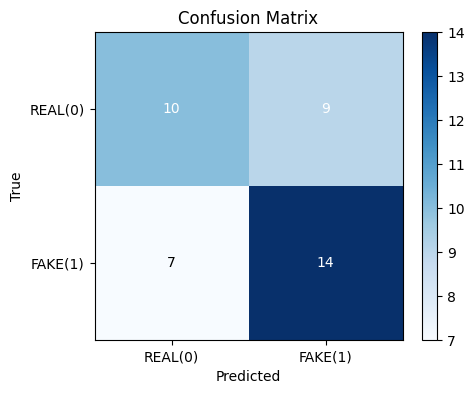


Classification Report:
              precision    recall  f1-score   support

     REAL(0)       0.59      0.53      0.56        19
     FAKE(1)       0.61      0.67      0.64        21

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



In [12]:
# Cell 9 — Confusion Matrix & Classification Report

y_pred = [p>0.5 for p in y_prob]
cm = confusion_matrix(y_true, y_pred)
labels = ['REAL(0)','FAKE(1)']

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]),
                 ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.xticks([0,1], labels); plt.yticks([0,1], labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [13]:
# Cell 10 — Save all results to Excel

import pandas as pd
from sklearn.metrics import classification_report

# 1) Epoch‐level metrics
epoch_df = pd.DataFrame(trainer.history)

# 2) ROC curve data
roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})

# 3) Precision‐Recall curve data
pr_df = pd.DataFrame({
    'recall': rc,
    'precision': pr
})

# 4) Confusion matrix
cm_df = pd.DataFrame(
    cm,
    index=labels,
    columns=labels
)

# 5) Classification report
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=labels,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# 6) Raw predictions & probabilities
preds_df = pd.DataFrame({
    'y_true':   y_true,
    'y_prob':  y_prob
})

# === Write to Excel with multiple sheets ===
out_file = "MobileNet_results.xlsx"
with pd.ExcelWriter(out_file, engine='openpyxl') as writer:
    epoch_df.to_excel(writer, sheet_name='epoch_metrics', index=False)
    roc_df.to_excel(writer, sheet_name='roc_curve',     index=False)
    pr_df.to_excel(writer, sheet_name='pr_curve',      index=False)
    cm_df.to_excel(writer, sheet_name='confusion_matrix')
    report_df.to_excel(writer, sheet_name='class_report')
    preds_df.to_excel(writer, sheet_name='predictions',  index=False)

print(f"✅ All results saved to {out_file}")


✅ All results saved to MobileNet_results.xlsx
